# About Dataset

Features:
fraud_bool (boolean) = (1 if fraud, 0 if legit).

income (numeric) = Annual income of the applicant in quantiles. Ranges between [0, 1].

name_email_similarity (numeric) = Metric of similarity between email and applicant’s name. Higher values represent higher similarity. Ranges

prev_address_months_count (numeric) = Number of months in previous registered address of the applicant, i.e. the applicant’s previous residence, if applicable. Ranges between [-1, 380] months (-1 is a missing value).

current_address_months_count (numeric) = Months in currently registered address of the applicant. Ranges between [-1, 429] months (-1 is a missing value).

customer_age (numeric) = Applicant’s age in bins per decade (e.g, 20-29 is represented as 20). Ranges between [10, 90] years.

days_since_request (numeric): Number of days passed since application was done. Ranges between [0, 79] days.

intended_balcon_amount (numeric): Initial transferred amount for application. Ranges between [–16, 114] (negatives are missing values).

payment_type (categorical): Credit payment plan type. 5 possible (anonymized) values.

zip_count_4w (numeric): Number of applications within same zip code in last 4 weeks. Ranges between [1, 6830].

velocity_6h (numeric): Velocity of total applications made in last 6 hours i.e., average number of applications per hour in the last 6 hours. Ranges between [–175, 16818].

velocity_24h (numeric): Velocity of total applications made in last 24 hours i.e., average number of applications per hour in the last 24 hours. Ranges between [1297, 9586].

velocity_4w (numeric): Velocity of total applications made in last 4 weeks i.e., average number of applications per hour in the last 4 weeks. Ranges between [2825, 7020].

bank_branch_count_8w (numeric): Number of total applications in the selected bank branch in last 8 weeks. Ranges between [0, 2404].

date_of_birth_distinct_emails_4w (numeric): Number of emails for applicants with same date of birth in last 4 weeks. Ranges between [0, 39].

employment_status (categorical): Employment status of the applicant. 7 possible (anonymized) values.

credit_risk_score (numeric): Internal score of application risk. Ranges between [–191, 389].

email_is_free (binary): Domain of application email (either free or paid).

housing_status (categorical): Current residential status for applicant. 7 possible (anonymized) values.

phone_home_valid (binary): Validity of provided home phone.

phone_mobile_valid (binary): Validity of provided mobile phone.

bank_months_count (numeric): How old is previous account (if held) in months. Ranges between [–1, 32] months (–1 is a missing value).

has_other_cards (binary): If applicant has other cards from the same banking company.

proposed_credit_limit (numeric): Applicant’s proposed credit limit. Ranges between [200, 2000].

foreign_request (binary): If origin country of request is different from bank’s country.

source (categorical): Online source of application. Either browser (INTERNET) or app (TELEAPP).

session_length_in_minutes (numeric): Length of user session in banking website in minutes. Ranges between [–1, 107] minutes (–1 is a missing value).

device_os (categorical): Operative system of device that made request. Possible values are: Windows, macOS, Linux, X11, or other.

keep_alive_session (binary): User option on session logout.

device_distinct_emails (numeric): Number of distinct emails in banking website from the used device in last 8 weeks. Ranges between [–1, 2] emails (–1 is a missing value).

device_fraud_count (numeric): Number of fraudulent applications with used device. Ranges between [0, 1].

month (numeric): Month where the application was made. Ranges between [0, 7].

Link dataset: https://www.kaggle.com/datasets/sgpjesus/bank-account-fraud-dataset-neurips-2022

In [108]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# Load Dataset

In [101]:
data = pd.read_csv("/kaggle/input/bank-account-fraud-dataset-neurips-2022/Base.csv", nrows=200_000)
data

,fraud_bool,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,payment_type,zip_count_4w,...,has_other_cards,proposed_credit_limit,foreign_request,source,session_length_in_minutes,device_os,keep_alive_session,device_distinct_emails_8w,device_fraud_count,month
0,0,0.3,0.986506,-1,25,40,0.006735,102.453711,AA,1059,...,0,1500.0,0,INTERNET,16.224843,linux,1,1,0,0
1,0,0.8,0.617426,-1,89,20,0.010095,-0.849551,AD,1658,...,0,1500.0,0,INTERNET,3.363854,other,1,1,0,0
2,0,0.8,0.996707,9,14,40,0.012316,-1.490386,AB,1095,...,0,200.0,0,INTERNET,22.730559,windows,0,1,0,0
3,0,0.6,0.475100,11,14,30,0.006991,-1.863101,AB,3483,...,0,200.0,0,INTERNET,15.215816,linux,1,1,0,0
4,0,0.9,0.842307,-1,29,40,5.742626,47.152498,AA,2339,...,0,200.0,0,INTERNET,3.743048,other,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995,0,0.5,0.528804,26,13,20,0.018300,51.504923,AA,2074,...,0,200.0,0,INTERNET,3.871854,other,1,1,0,1
199996,0,0.4,0.079761,137,14,30,4.018075,-0.830555,AC,1577,...,0,200.0,0,INTERNET,5.545133,other,1,1,0,1
199997,0,0.4,0.161715,-1,58,20,0.013512,-1.329180,AB,2810,...,0,200.0,0,INTERNET,4.119012,other,1,1,0,1
199998,0,0.6,0.136501,25,4,20,0.003101,-1.465252,AB,3215,...,0,200.0,0,INTERNET,3.060711,linux,0,1,0,1


# Data Understanding

In [94]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 32 columns):
 #   Column                            Non-Null Count    Dtype  
---  ------                            --------------    -----  
 0   fraud_bool                        1000000 non-null  int64  
 1   income                            1000000 non-null  float64
 2   name_email_similarity             1000000 non-null  float64
 3   prev_address_months_count         1000000 non-null  int64  
 4   current_address_months_count      1000000 non-null  int64  
 5   customer_age                      1000000 non-null  int64  
 6   days_since_request                1000000 non-null  float64
 7   intended_balcon_amount            1000000 non-null  float64
 8   payment_type                      1000000 non-null  object 
 9   zip_count_4w                      1000000 non-null  int64  
 10  velocity_6h                       1000000 non-null  float64
 11  velocity_24h                      1000

In [96]:
data.describe()

,fraud_bool,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,zip_count_4w,velocity_6h,...,phone_mobile_valid,bank_months_count,has_other_cards,proposed_credit_limit,foreign_request,session_length_in_minutes,keep_alive_session,device_distinct_emails_8w,device_fraud_count,month
count,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,2.000000e+05,200000.000000,200000.000000,200000.000000,...,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.0,200000.000000
mean,0.010630,0.537184,0.496496,16.557660,90.367210,33.392550,9.422854e-01,9.647162,2003.240790,7225.366960,...,0.884425,11.686195,0.183595,567.759700,0.033180,8.189715,0.648550,1.028535,0.0,0.337800
std,0.102553,0.290785,0.286043,44.278904,91.934497,12.327525,4.707124e+00,20.696069,1263.268756,3116.262052,...,0.319715,11.922711,0.387155,544.830232,0.179107,8.679465,0.477424,0.215873,0.0,0.472961
min,0.000000,0.100000,0.000032,-1.000000,-1.000000,10.000000,4.036860e-09,-13.202786,2.000000,-29.235883,...,0.000000,-1.000000,0.000000,190.000000,0.000000,-1.000000,0.000000,-1.000000,0.0,0.000000
25%,0.000000,0.200000,0.225106,-1.000000,22.000000,20.000000,7.039064e-03,-1.184425,1073.000000,4981.488358,...,1.000000,1.000000,0.000000,200.000000,0.000000,3.469201,0.000000,1.000000,0.0,0.000000
50%,0.000000,0.600000,0.513060,-1.000000,53.000000,30.000000,1.489647e-02,-0.809822,1584.000000,7380.364739,...,1.000000,9.000000,0.000000,200.000000,0.000000,5.341666,1.000000,1.000000,0.0,0.000000
75%,0.000000,0.800000,0.745551,11.000000,142.000000,40.000000,2.593825e-02,14.557498,2693.250000,9051.834391,...,1.000000,25.000000,0.000000,1000.000000,0.000000,9.212150,1.000000,1.000000,0.0,1.000000
max,1.000000,0.900000,0.999999,367.000000,425.000000,90.000000,7.658148e+01,112.956928,6700.000000,16715.565404,...,1.000000,32.000000,1.000000,2100.000000,1.000000,83.213536,1.000000,2.000000,0.0,1.000000


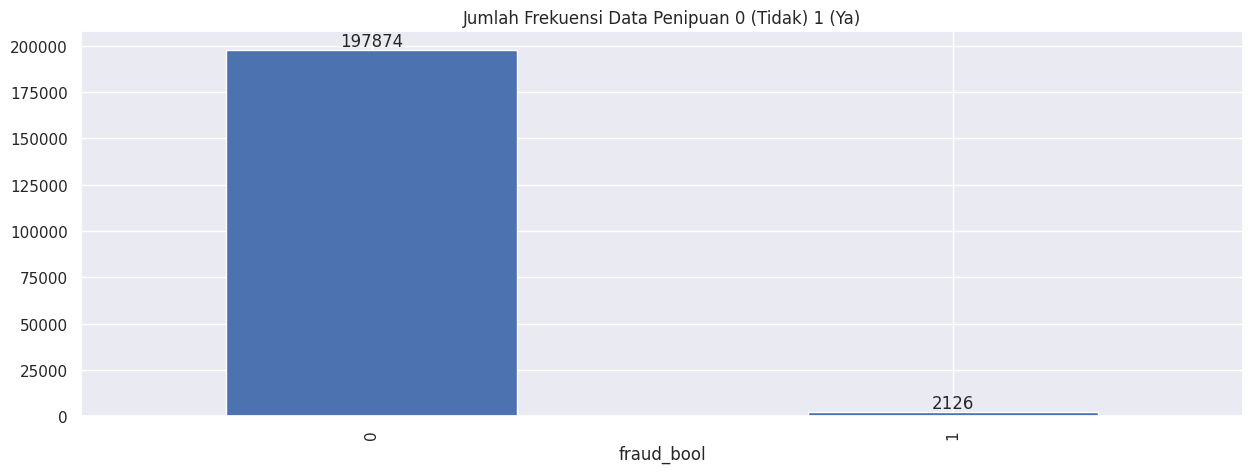

In [116]:
plot = data["fraud_bool"].value_counts()
ax = plot.plot.bar(figsize=(15, 5))
ax.set_title("Jumlah Frekuensi Data Penipuan 0 (Tidak) 1 (Ya)")

for container in ax.containers:
    ax.bar_label(container)

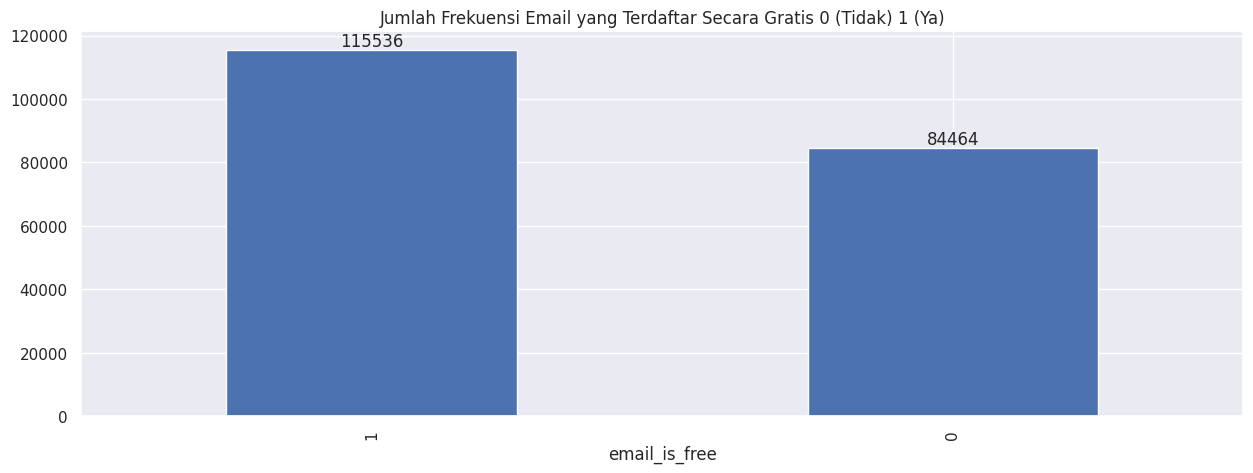

In [115]:
plot = data["email_is_free"].value_counts()
ax = plot.plot.bar(figsize=(15, 5))
ax.set_title("Jumlah Frekuensi Email yang Terdaftar Secara Gratis 0 (Tidak) 1 (Ya)")

for container in ax.containers:
    ax.bar_label(container)

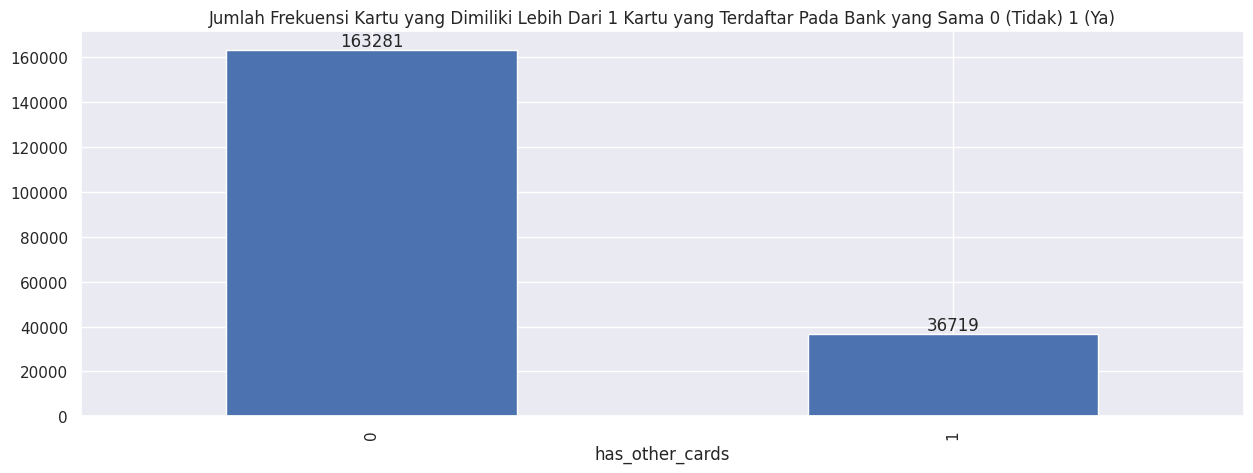

In [117]:
plot = data["has_other_cards"].value_counts()
ax = plot.plot.bar(figsize=(15, 5))
ax.set_title("Jumlah Frekuensi Kartu yang Dimiliki Lebih Dari 1 Kartu yang Terdaftar Pada Bank yang Sama 0 (Tidak) 1 (Ya)")

for container in ax.containers:
    ax.bar_label(container)

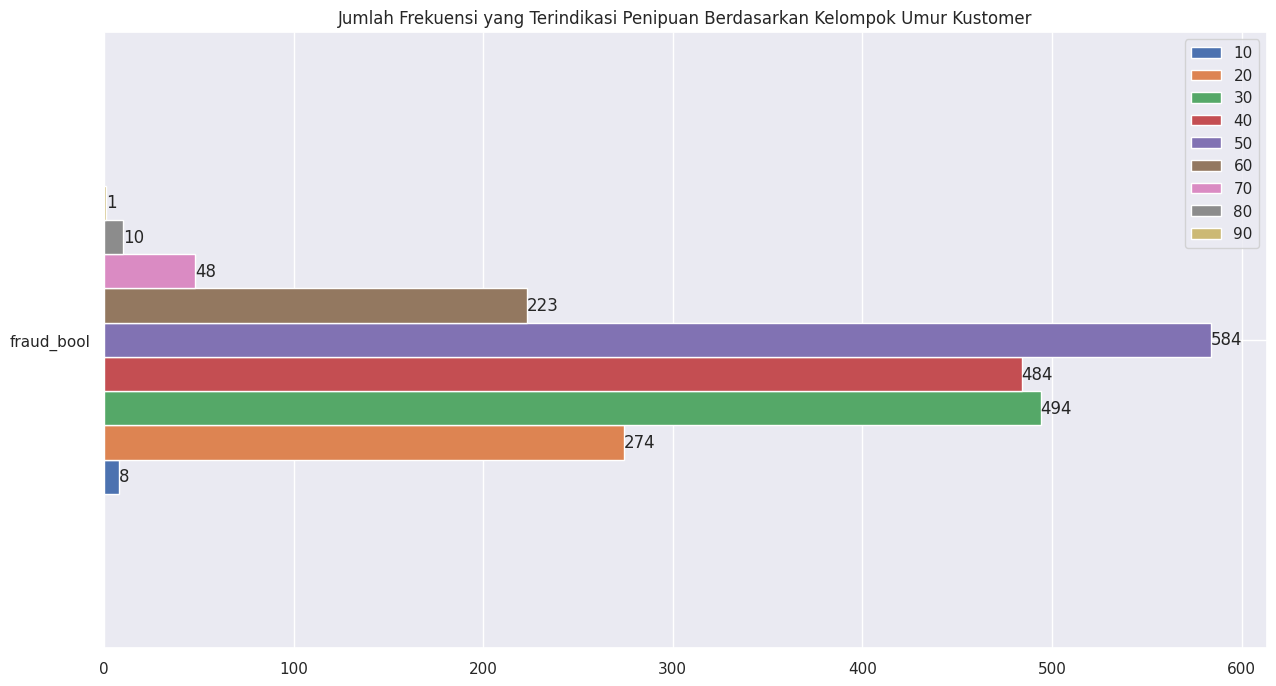

In [118]:
plot = pd.pivot_table(data=data, values="fraud_bool", columns="customer_age", aggfunc="sum")
ax = plot.plot.barh(figsize=(15, 8))
ax.set_title("Jumlah Frekuensi yang Terindikasi Penipuan Berdasarkan Kelompok Umur Kustomer")
ax.legend(loc="upper right")

for container in ax.containers:
    ax.bar_label(container)

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


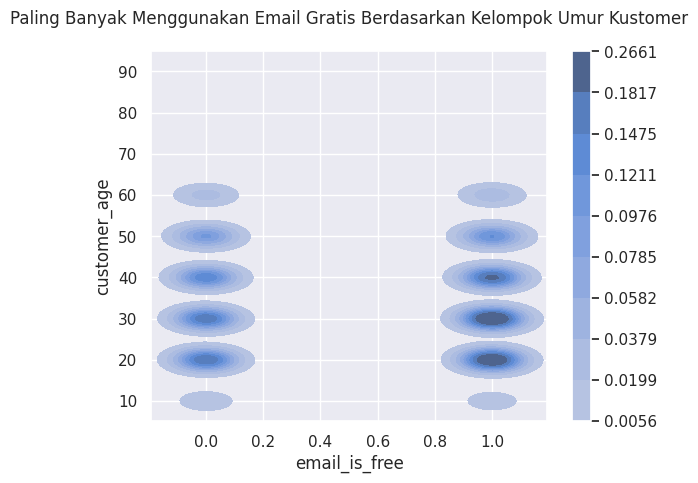

In [128]:
ax = sns.kdeplot(
    data=data,
    x="email_is_free",
    y="customer_age",
    cbar=True,
    fill=True
)
ax.set_title(
    "Paling Banyak Menggunakan Email Gratis Berdasarkan Kelompok Umur Kustomer",
    pad=20  # Atur jarak
)
plt.show()

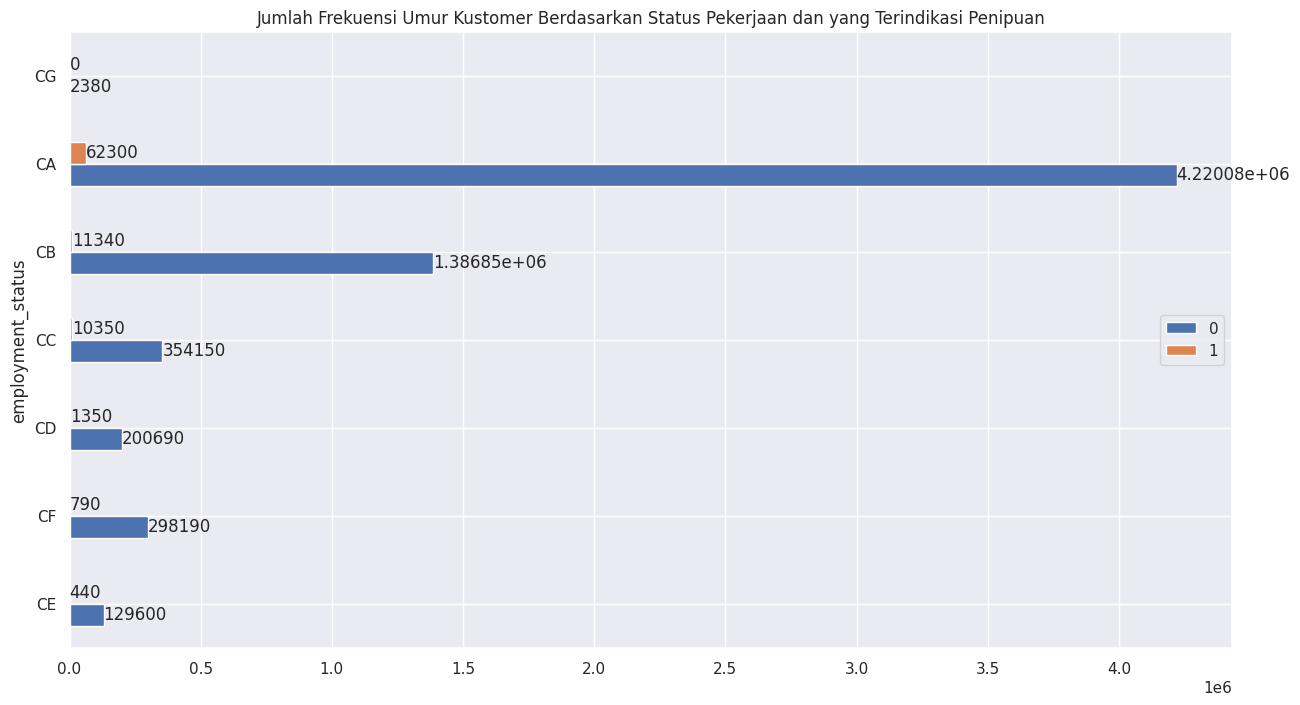

In [129]:
# Mengurutkan berdasarkan fitur fraud_bool 1
plot = data.groupby(["employment_status", "fraud_bool"])["customer_age"].sum().unstack().sort_values(by=1, ascending=True)
ax = plot.plot.barh(figsize=(15, 8))
ax.set_title("Jumlah Frekuensi Umur Kustomer Berdasarkan Status Pekerjaan dan yang Terindikasi Penipuan")
ax.legend(loc="center right")

for container in ax.containers:
    ax.bar_label(container)

In [130]:
categorical_features = data.select_dtypes(include=['object', 'category']).columns
numerical_features = data.select_dtypes(include=['int64', 'float64']).columns

In [131]:
def print_counts_categories_features(data):
    for col in categorical_features:
        plt.figure(figsize=(8, 5))
        counts = data[col].value_counts(dropna=False)
        counts.plot(kind='bar')
        plt.title(f'Distribusi Frekuensi Kategori: {col}')
        plt.xlabel(col)
        plt.ylabel('Jumlah')
        plt.xticks(rotation=45, ha='right')
        
        for i, count in enumerate(counts):
            plt.text(i, count + 0.5, str(count), ha='center', va='bottom', fontsize=9)
            
        plt.tight_layout()
        plt.show()

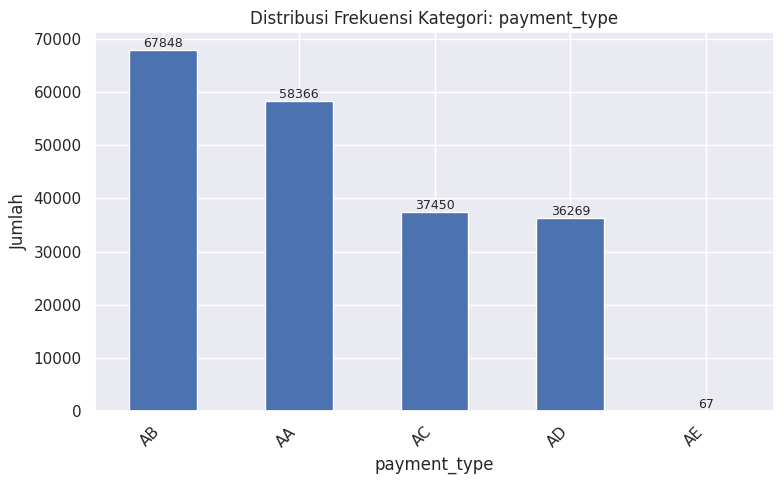

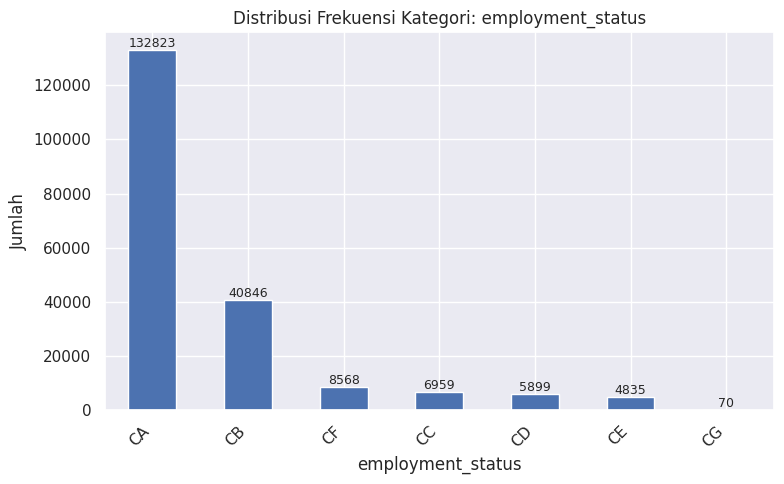

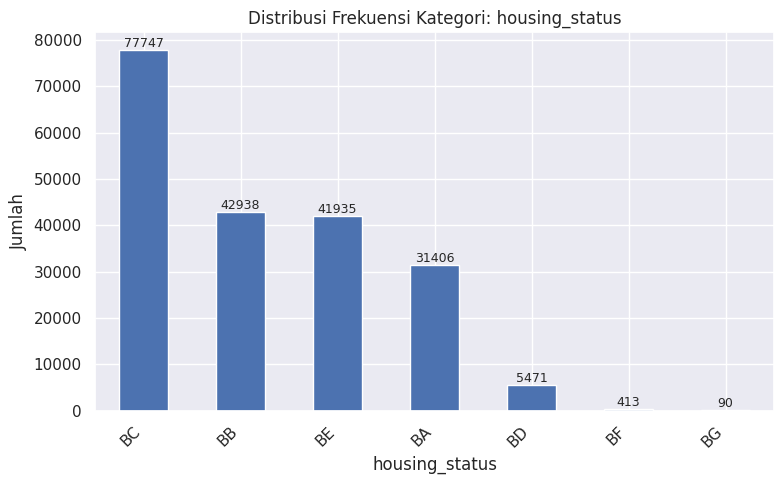

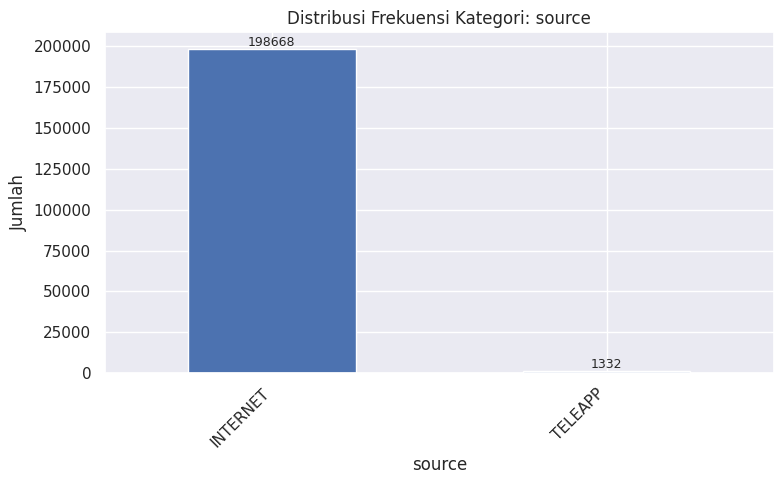

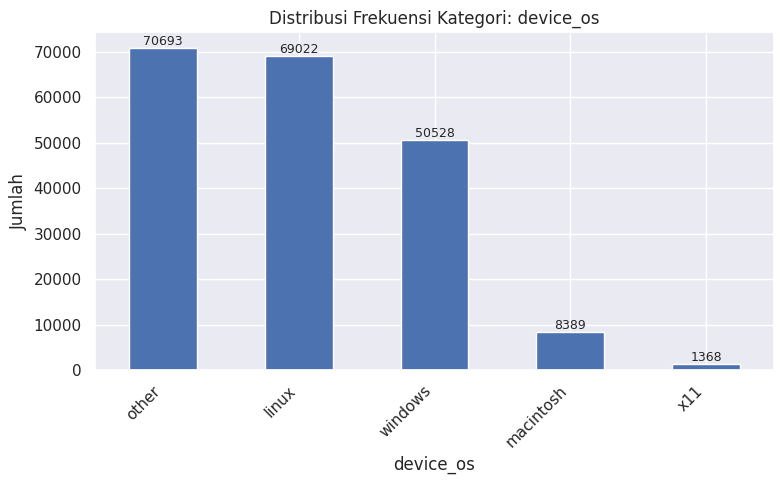

In [132]:
print_counts_categories_features(data)

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

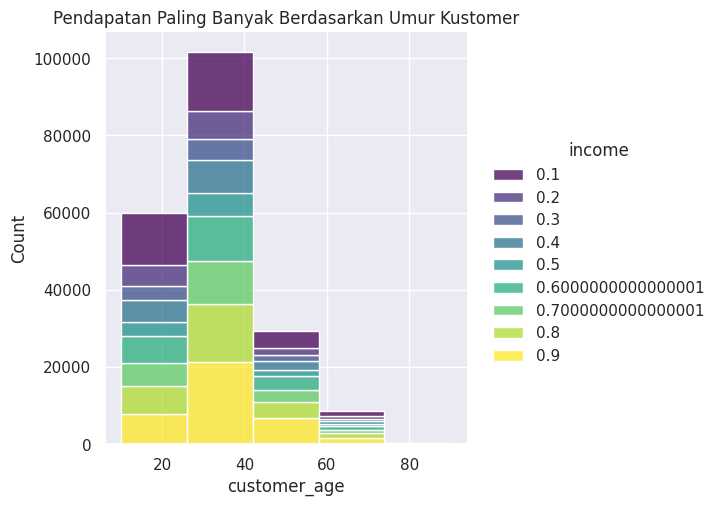

In [133]:
sns.displot(
    data=data, 
    bins=5, 
    x="customer_age", 
    hue="income", 
    multiple="stack", 
    palette="viridis").set(title="Pendapatan Paling Banyak Berdasarkan Umur Kustomer");

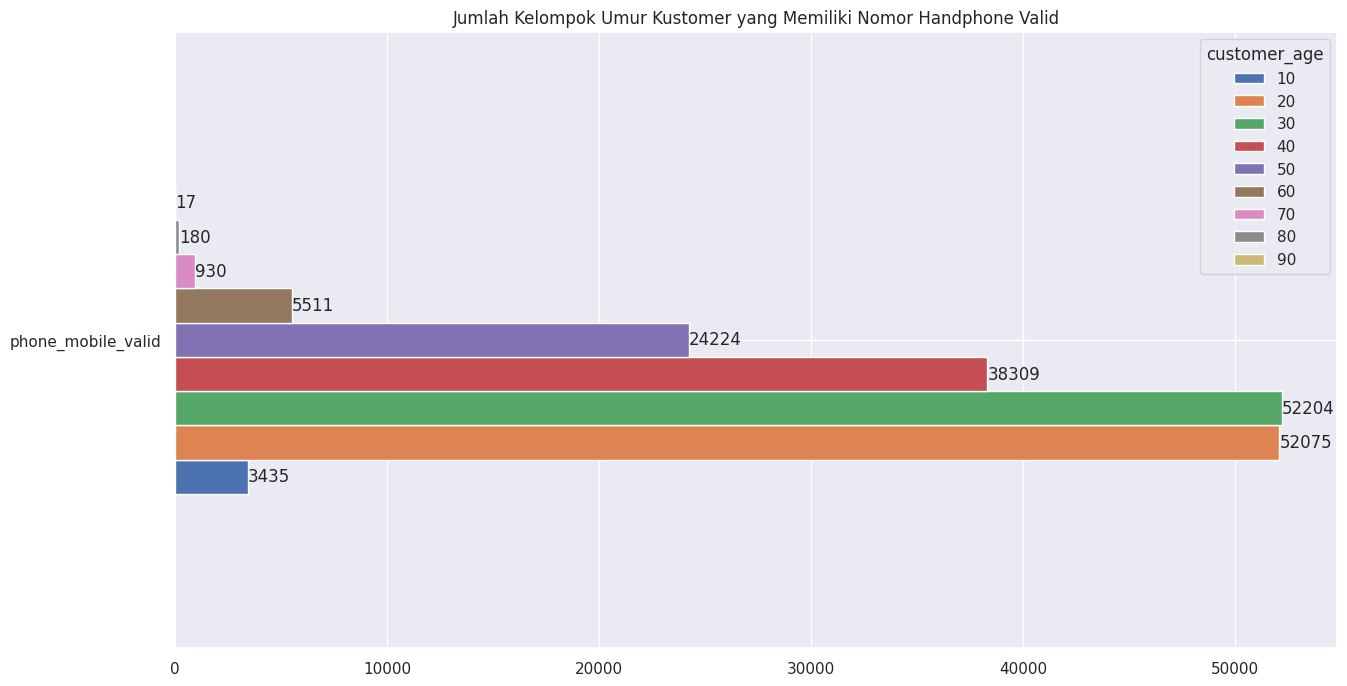

In [134]:
plot = pd.pivot_table(data=data, values="phone_mobile_valid", columns="customer_age", aggfunc="sum")
ax = plot.plot.barh(figsize=(15, 8))
ax.set_title("Jumlah Kelompok Umur Kustomer yang Memiliki Nomor Handphone Valid")

for container in ax.containers:
    ax.bar_label(container)

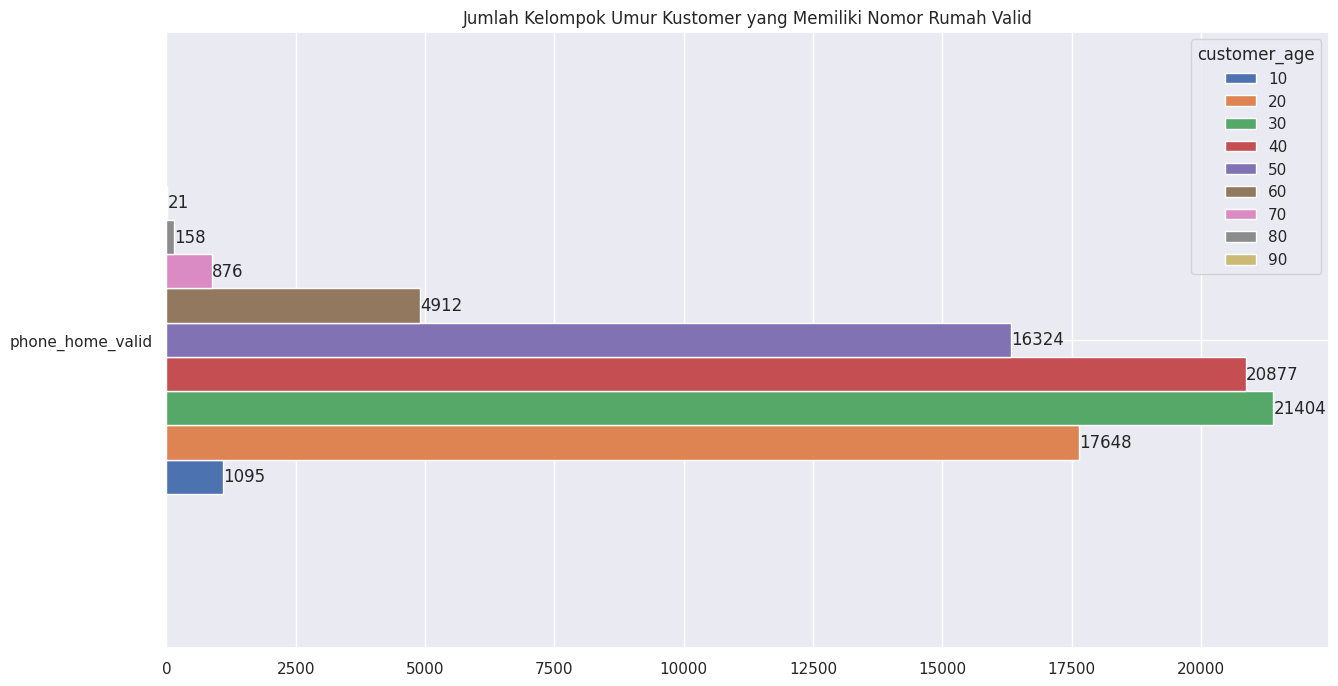

In [135]:
plot = pd.pivot_table(data=data, values="phone_home_valid", columns="customer_age", aggfunc="sum")
ax = plot.plot.barh(figsize=(15, 8))
ax.set_title("Jumlah Kelompok Umur Kustomer yang Memiliki Nomor Rumah Valid")

for container in ax.containers:
    ax.bar_label(container)

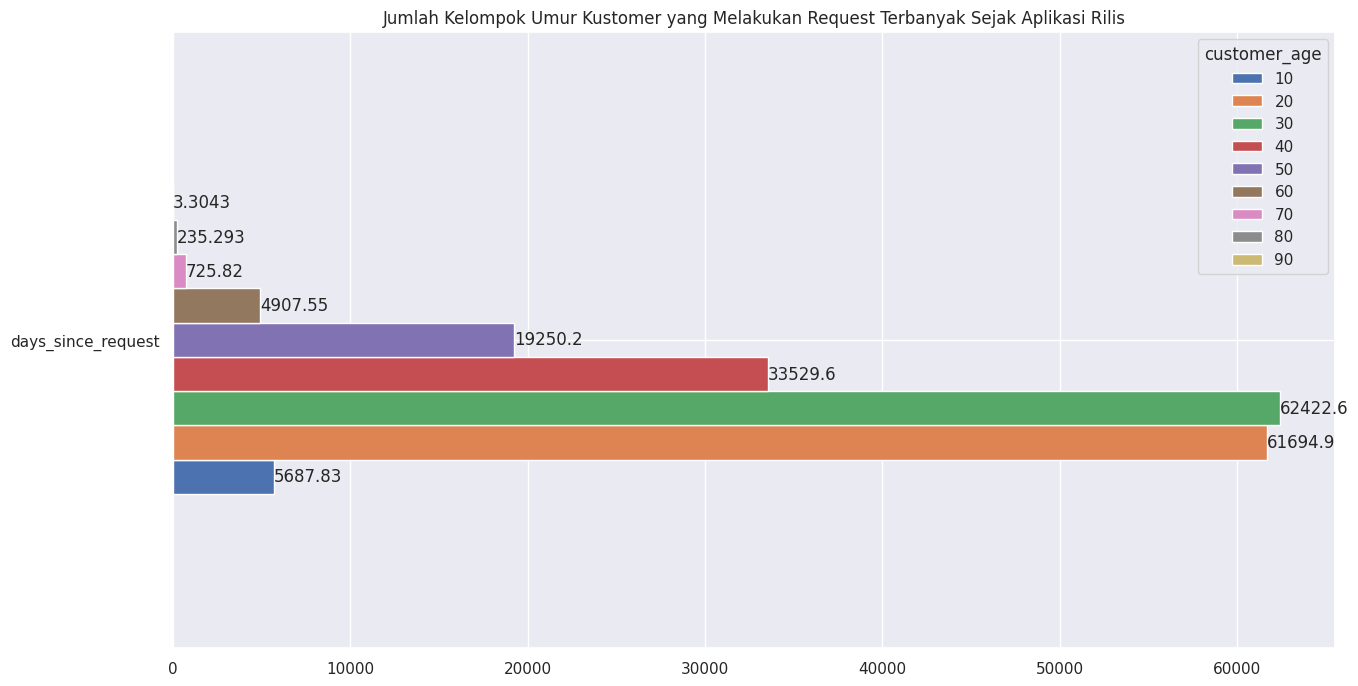

In [136]:
plot = pd.pivot_table(data=data, values="days_since_request", columns="customer_age", aggfunc="sum")
ax = plot.plot.barh(figsize=(15, 8))
ax.set_title("Jumlah Kelompok Umur Kustomer yang Melakukan Request Terbanyak Sejak Aplikasi Rilis")

for container in ax.containers:
    ax.bar_label(container)

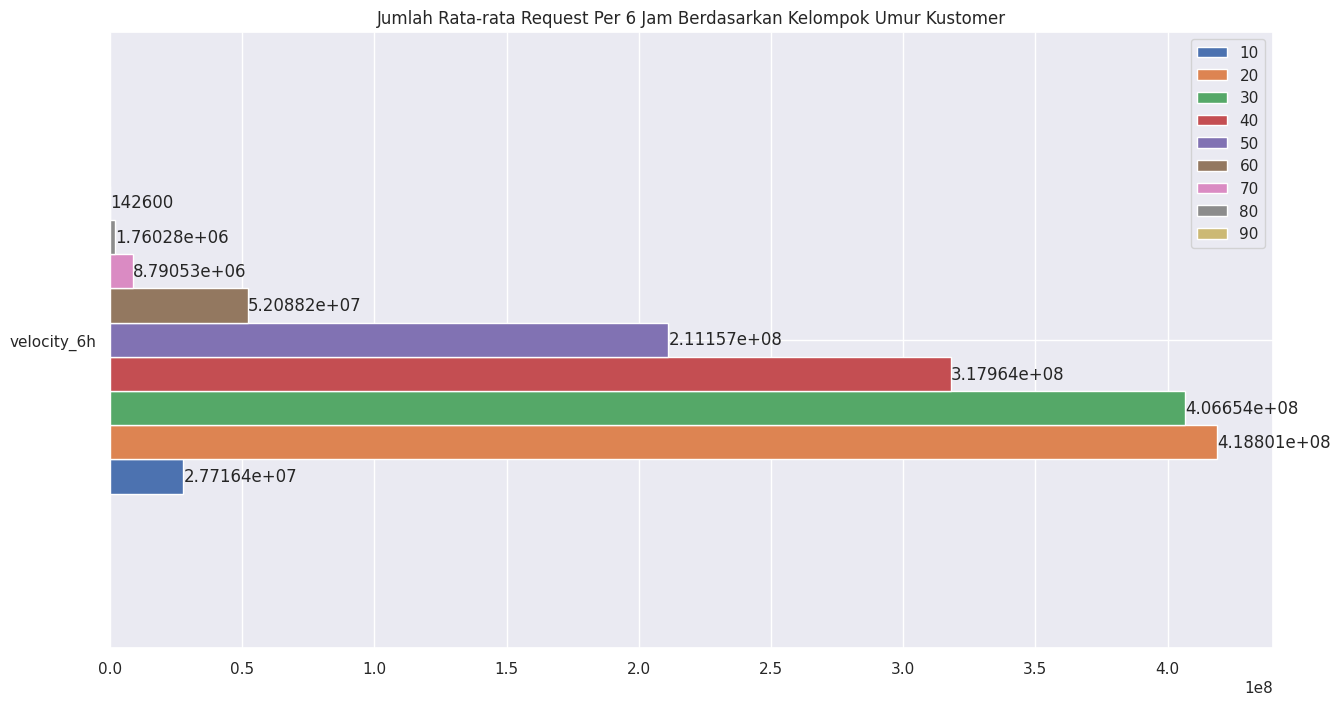

In [137]:
plot = pd.pivot_table(data=data, values="velocity_6h", columns="customer_age", aggfunc="sum")
ax = plot.plot.barh(figsize=(15, 8))
ax.set_title("Jumlah Rata-rata Request Per 6 Jam Berdasarkan Kelompok Umur Kustomer")
ax.legend(loc="upper right")

for container in ax.containers:
    ax.bar_label(container)

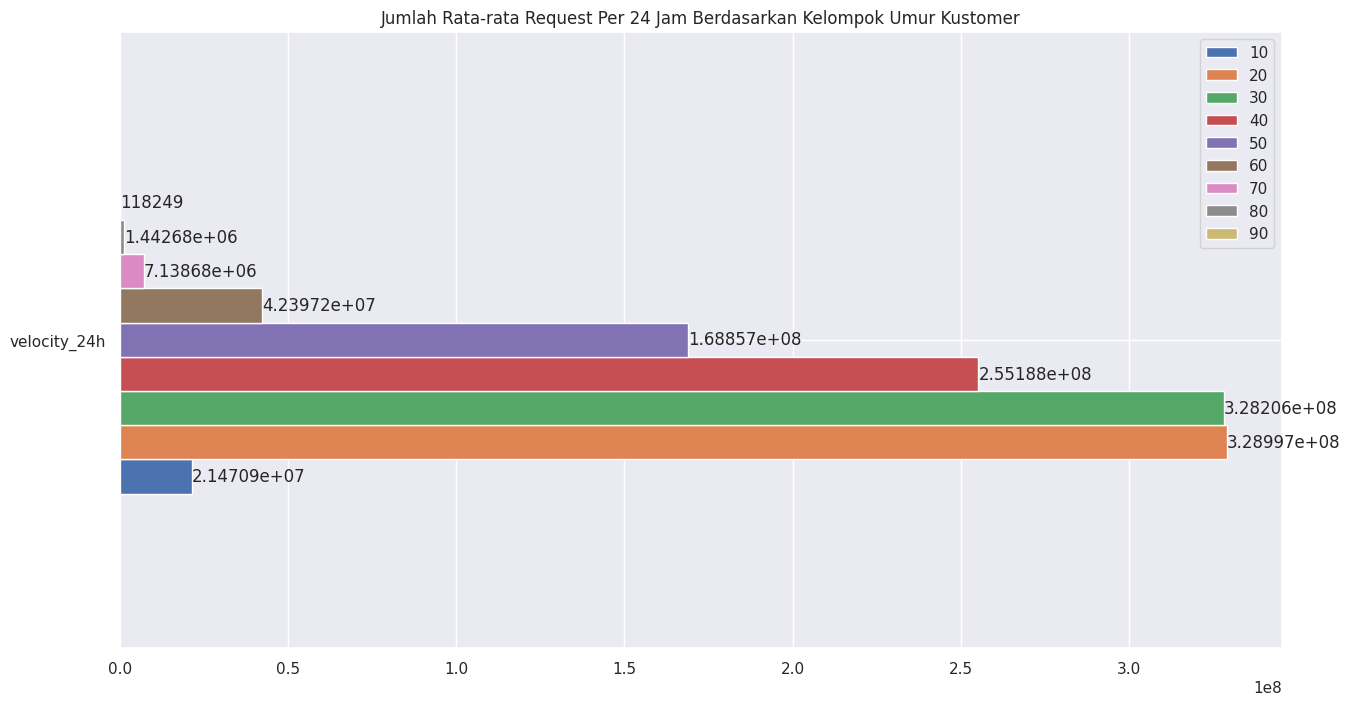

In [138]:
plot = pd.pivot_table(data=data, values="velocity_24h", columns="customer_age", aggfunc="sum")
ax = plot.plot.barh(figsize=(15, 8))
ax.set_title("Jumlah Rata-rata Request Per 24 Jam Berdasarkan Kelompok Umur Kustomer")
ax.legend(loc="upper right")

for container in ax.containers:
    ax.bar_label(container)

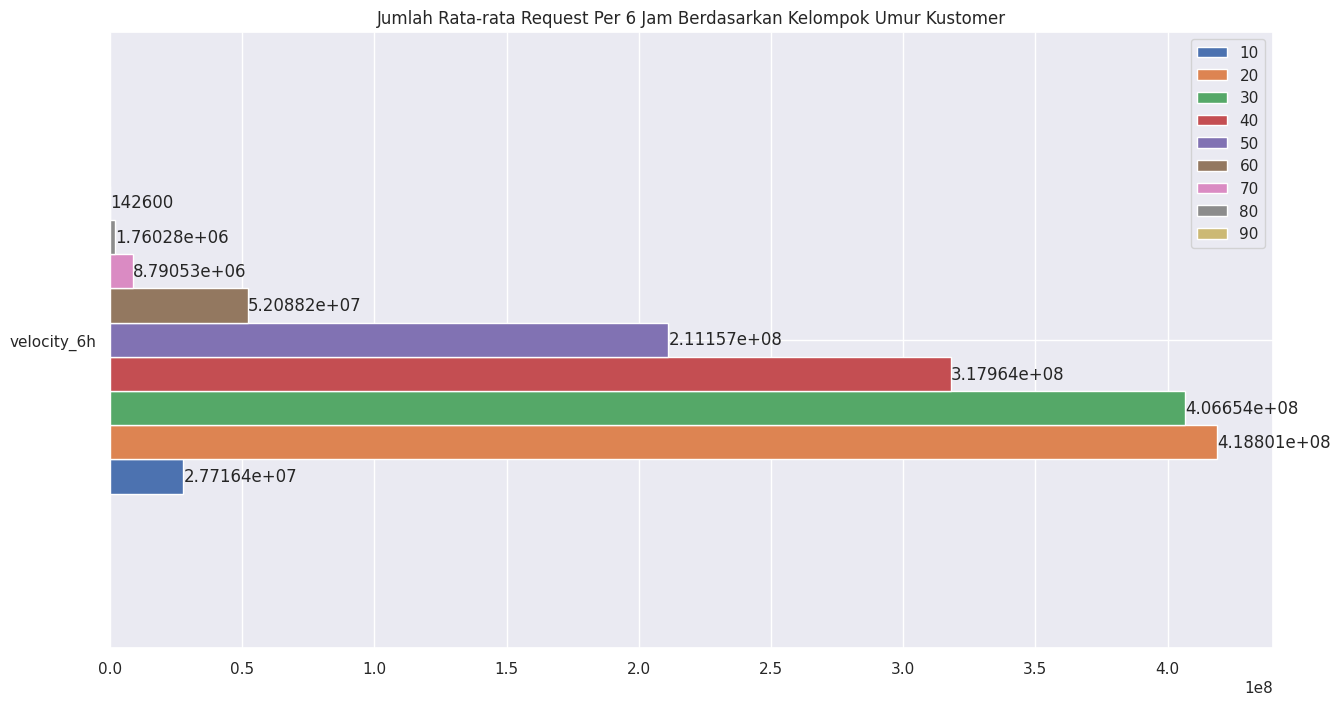

In [139]:
plot = pd.pivot_table(data=data, values="velocity_6h", columns="customer_age", aggfunc="sum")
ax = plot.plot.barh(figsize=(15, 8))
ax.set_title("Jumlah Rata-rata Request Per 6 Jam Berdasarkan Kelompok Umur Kustomer")
ax.legend(loc="upper right")

for container in ax.containers:
    ax.bar_label(container)

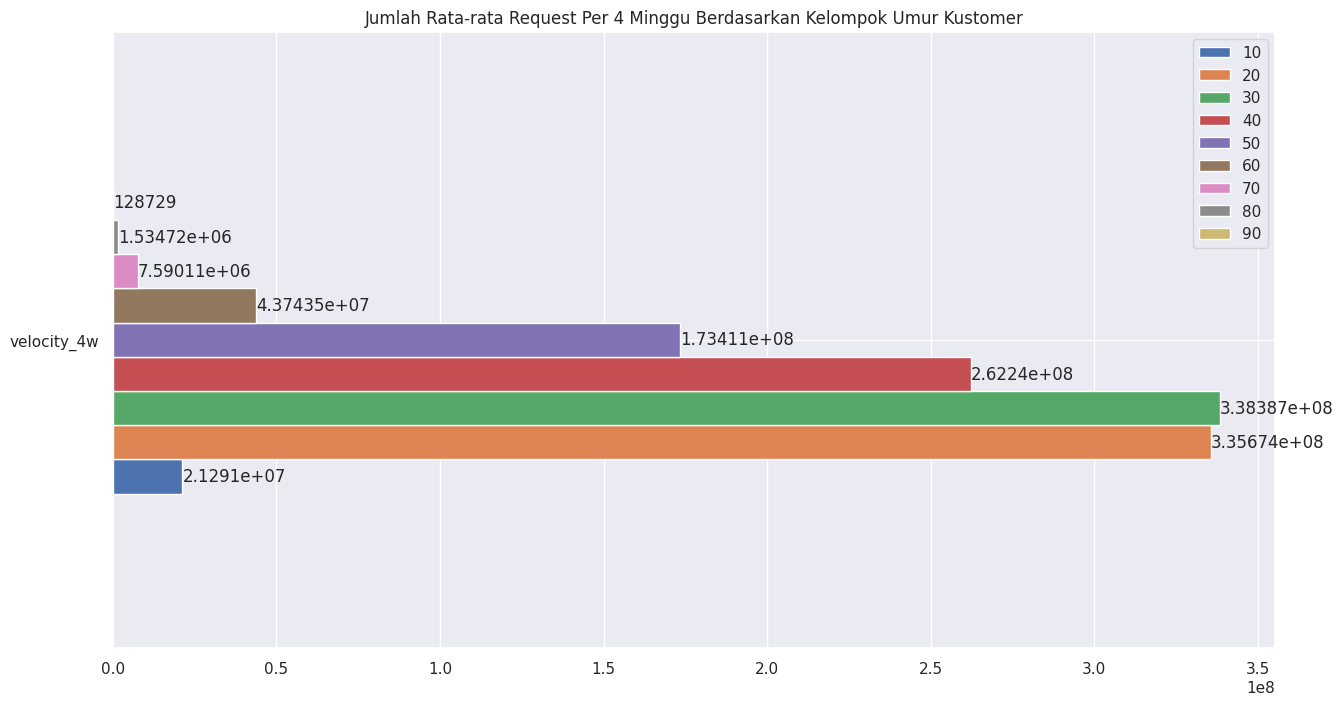

In [140]:
plot = pd.pivot_table(data=data, values="velocity_4w", columns="customer_age", aggfunc="sum")
ax = plot.plot.barh(figsize=(15, 8))
ax.set_title("Jumlah Rata-rata Request Per 4 Minggu Berdasarkan Kelompok Umur Kustomer")
ax.legend(loc="upper right")

for container in ax.containers:
    ax.bar_label(container)

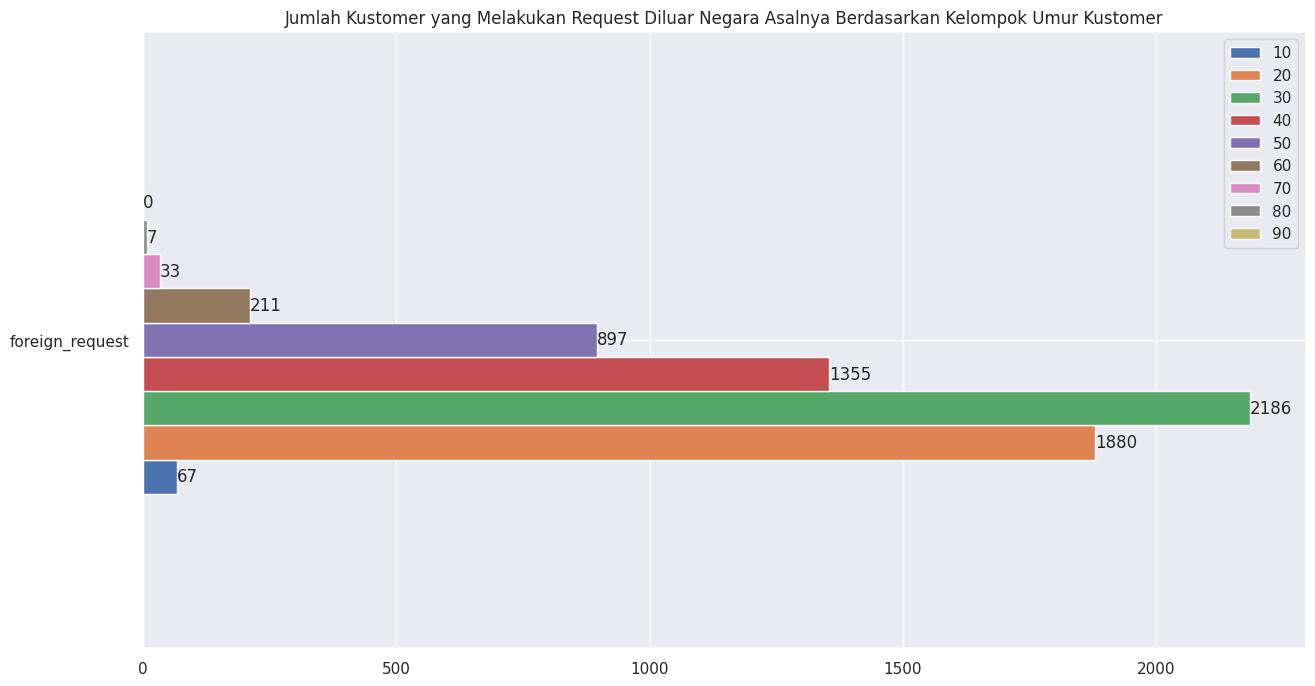

In [141]:
plot = pd.pivot_table(data=data, values="foreign_request", columns="customer_age", aggfunc="sum")
ax = plot.plot.barh(figsize=(15, 8))
ax.set_title("Jumlah Kustomer yang Melakukan Request Diluar Negara Asalnya Berdasarkan Kelompok Umur Kustomer")
ax.legend(loc="upper right")

for container in ax.containers:
    ax.bar_label(container)

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


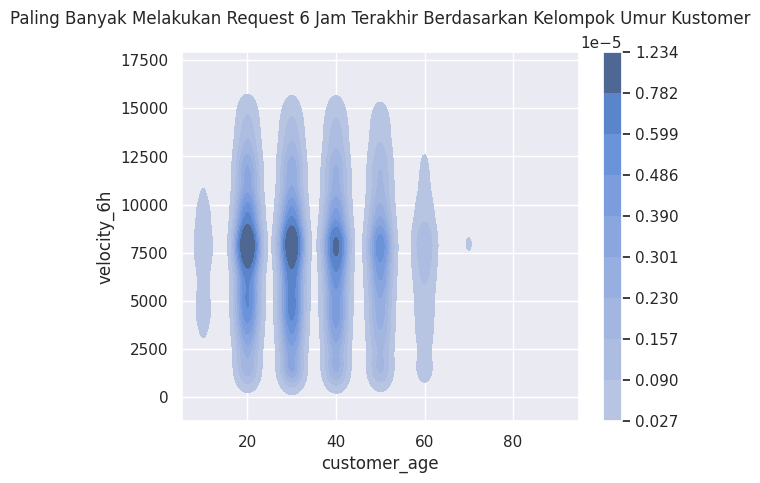

In [142]:
ax = sns.kdeplot(
    data=data,
    x="customer_age",
    y="velocity_6h",
    cbar=True,
    fill=True
)
ax.set_title(
    "Paling Banyak Melakukan Request 6 Jam Terakhir Berdasarkan Kelompok Umur Kustomer",
    pad=20  # Atur jarak
)
plt.show()

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

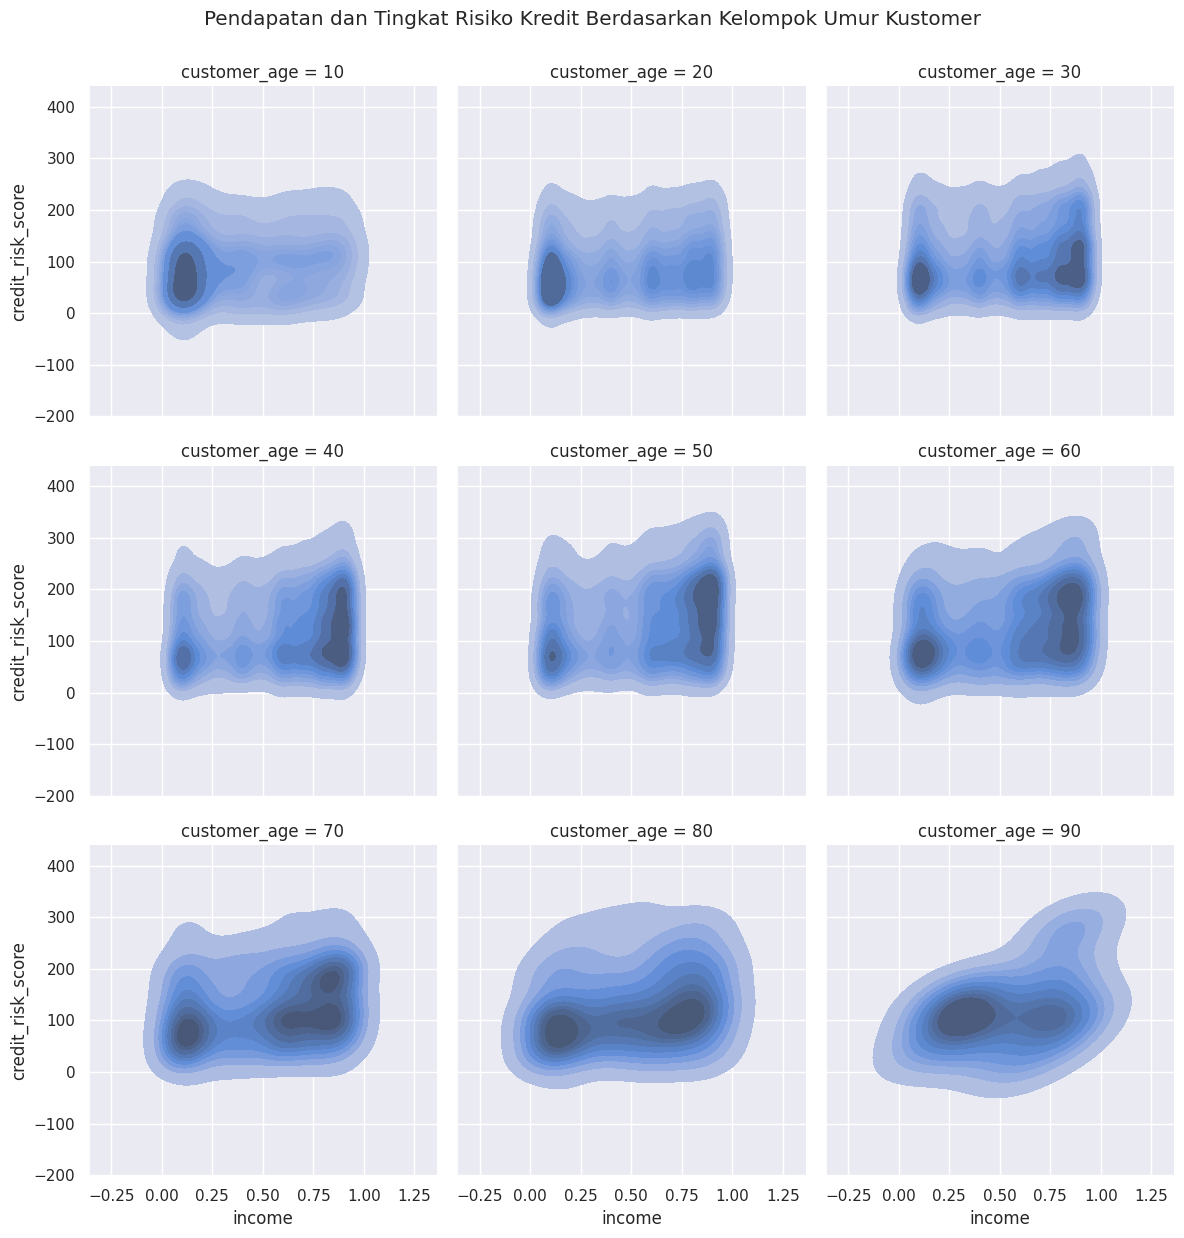

In [143]:
g = sns.FacetGrid(data, col="customer_age", height=4, col_wrap=3)
g.map(sns.kdeplot, "income", "credit_risk_score", fill=True)
g.figure.suptitle(
    "Pendapatan dan Tingkat Risiko Kredit Berdasarkan Kelompok Umur Kustomer",
    y=1.03,  # Atur posisi vertikal judul agar tidak menimpa judul subplot
);

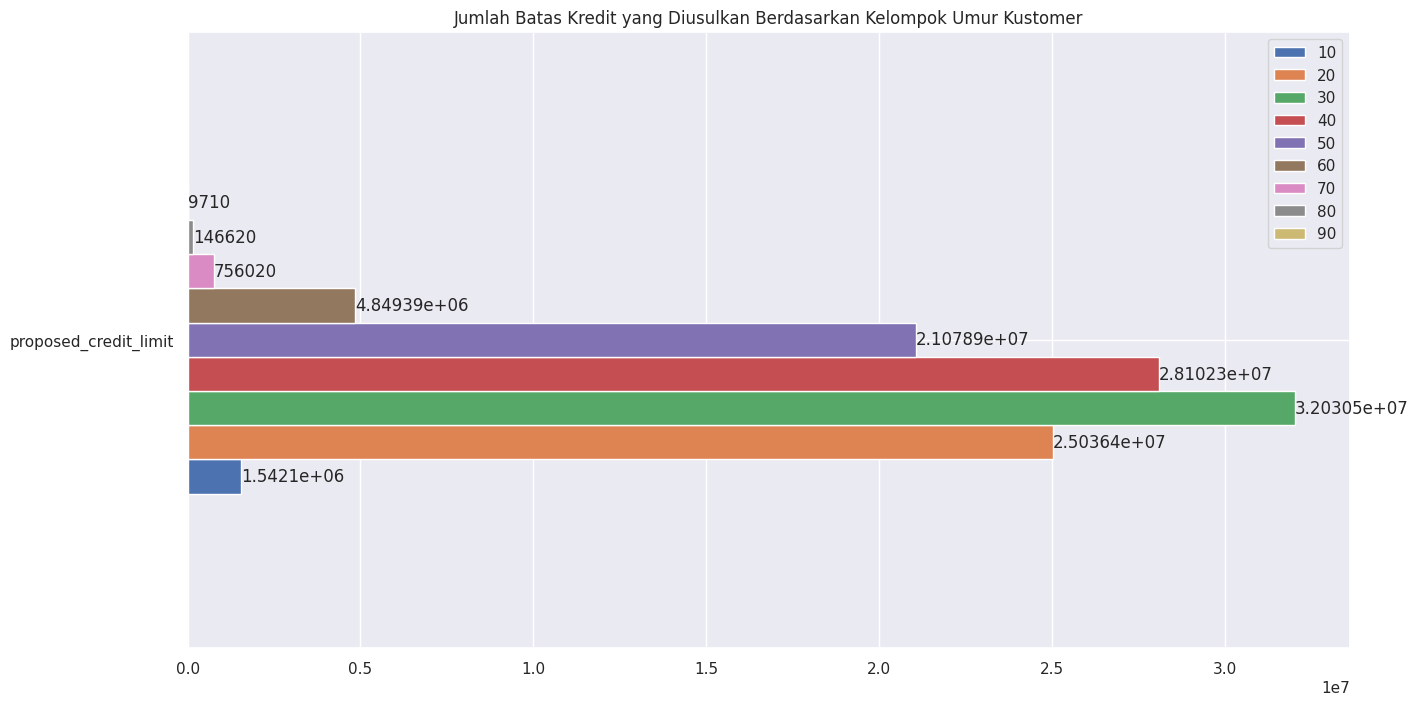

In [144]:
plot = pd.pivot_table(data=data, values="proposed_credit_limit", columns="customer_age", aggfunc="sum")
ax = plot.plot.barh(figsize=(15, 8))
ax.set_title("Jumlah Batas Kredit yang Diusulkan Berdasarkan Kelompok Umur Kustomer")
ax.legend(loc="upper right")

for container in ax.containers:
    ax.bar_label(container)

In [145]:
pivot_table = pd.pivot_table(data=data, values="intended_balcon_amount", index="employment_status", columns="customer_age", aggfunc="sum")
pivot_table

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


customer_age,10,20,30,40,50,60,70,80,90
employment_status,,,,,,,,,
CA,40849.135002,398366.366257,404005.944887,274094.487102,182372.590922,29349.265037,4261.372792,778.915244,61.680370
CB,4428.285523,96135.338577,133619.033642,90890.470184,52905.587323,13931.113632,3306.536778,433.899264,72.081264
CC,146.070094,2225.705514,2892.437521,4658.424891,16528.111924,15269.675795,3925.968057,1178.982478,95.621568
CD,524.722790,8770.111852,9276.418304,7948.205562,6233.688817,1228.497620,94.288081,4.950899,NaN
CE,5450.404809,35716.942139,11105.288645,8057.795302,5647.167170,1288.332608,490.985384,118.467623,NaN
CF,171.094419,10301.834118,14669.475432,12507.104339,9820.382624,1769.868631,600.809985,133.871097,-1.457200
CG,NaN,135.780080,305.936553,131.557801,146.789068,NaN,NaN,NaN,NaN


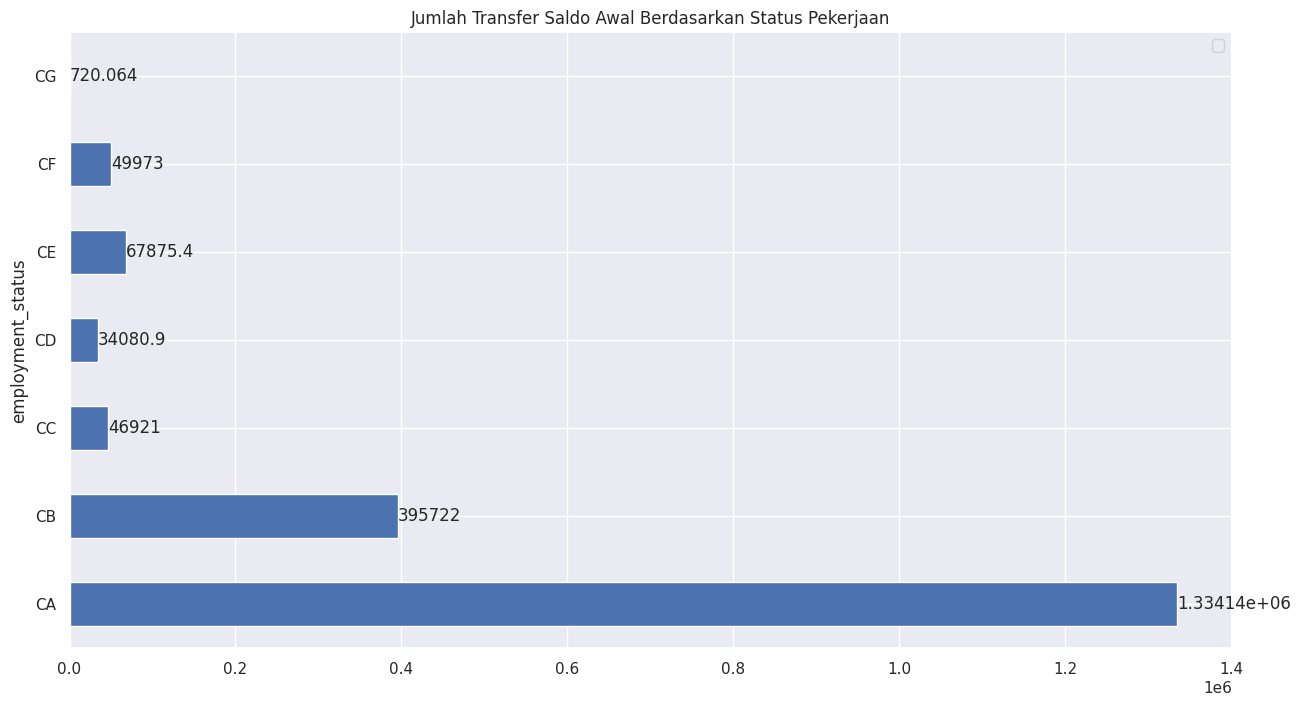

In [146]:
ax = pivot_table.sum(axis=1).plot.barh(figsize=(15, 8))
ax.set_title("Jumlah Transfer Saldo Awal Berdasarkan Status Pekerjaan")
ax.legend(loc="upper right")

for container in ax.containers:
    ax.bar_label(container)

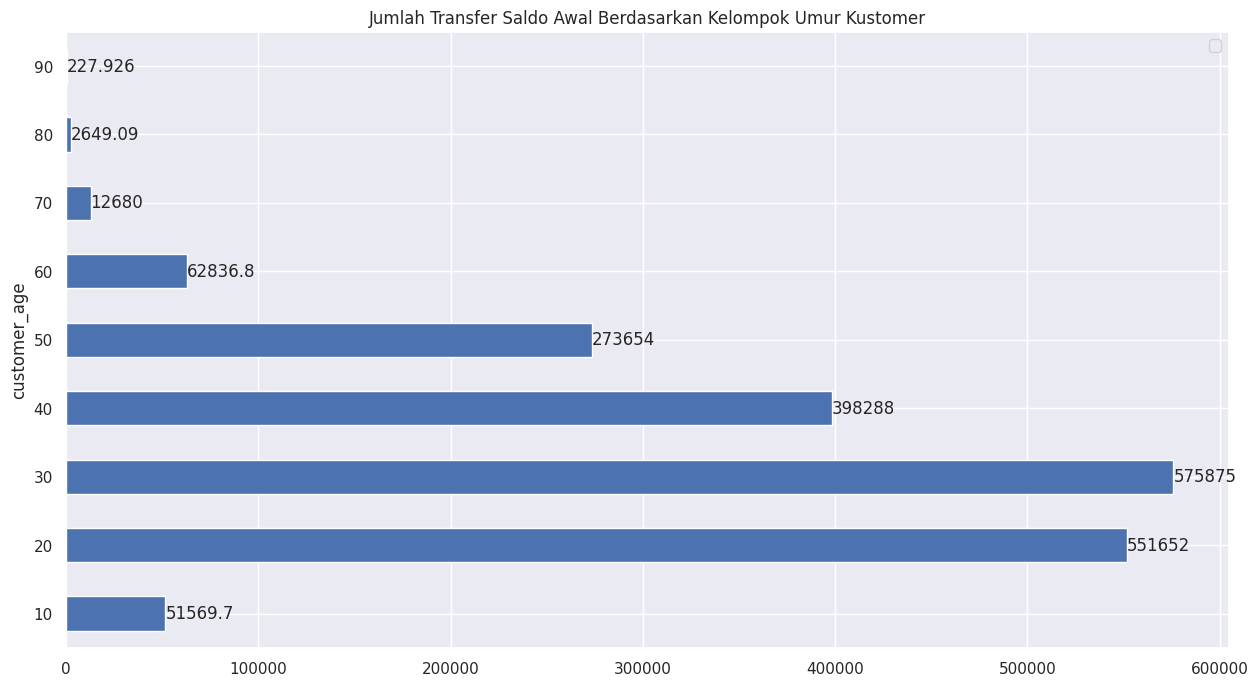

In [147]:
ax = pivot_table.sum(axis=0).plot.barh(figsize=(15, 8))
ax.set_title("Jumlah Transfer Saldo Awal Berdasarkan Kelompok Umur Kustomer")
ax.legend(loc="upper right")

for container in ax.containers:
    ax.bar_label(container)

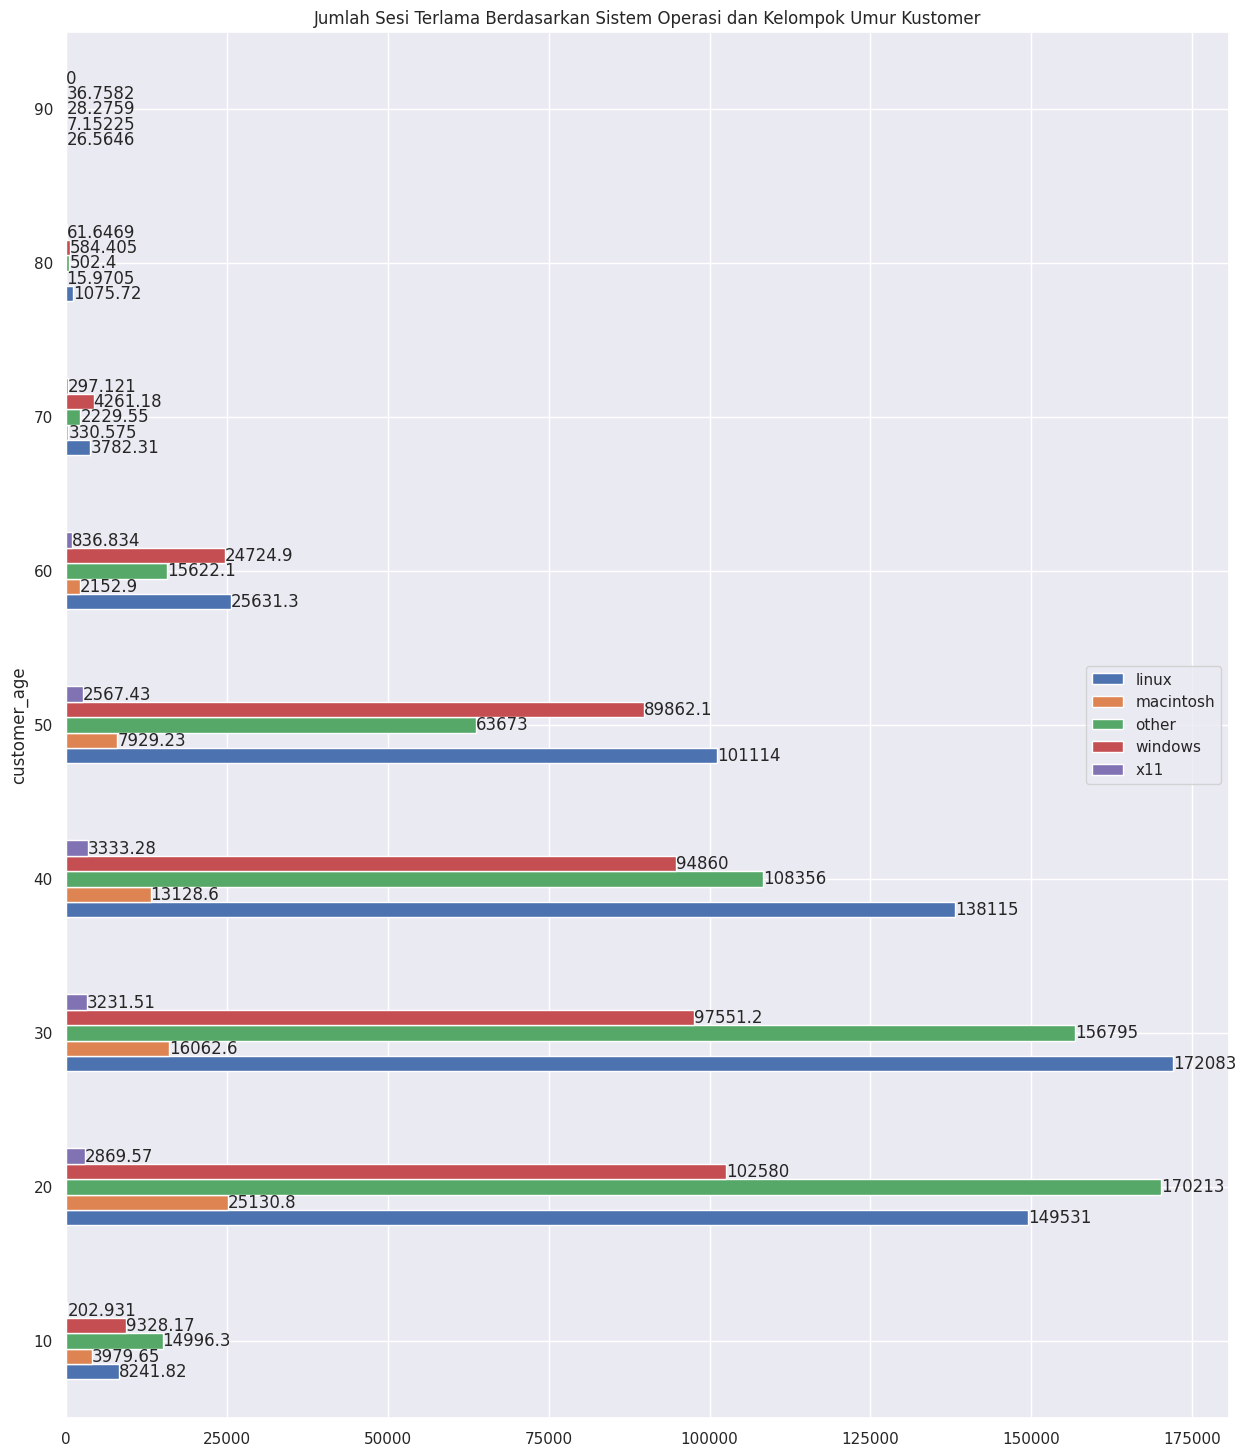

In [148]:
data["session_length_in_minutes"]
plot = data.groupby(["customer_age", "device_os"])["session_length_in_minutes"].sum().unstack()
ax = plot.plot.barh(figsize=(15, 18))
ax.set_title("Jumlah Sesi Terlama Berdasarkan Sistem Operasi dan Kelompok Umur Kustomer")
ax.legend(loc="center right")

for container in ax.containers:
    ax.bar_label(container)

# Data Preparation

In [149]:
data_duplicated = data.duplicated().sum()
print(f"Jumlah data duplikat = {data_duplicated} data")

Jumlah data duplikat = 0 data


In [150]:
categories_features

NameError: name 'categories_features' is not defined

In [ ]:
# Encoder categories
le = LabelEncoder()

# 3. Latih (fit) dan transformasi (transform) kolom 'Kategori'
# Metode fit_transform melakukan keduanya dalam satu langkah
df['Kategori_Encoded'] = le.fit_transform(df['Kategori'])